# 2 Modeling<a id='2_Modeling'></a>

## 2.1 Contents<a id='2.1_Contents'></a>
* [2 Modeling](#2_Modeling)
    * [2.1 Contents](#2.1_Contents)
    * [2.2 Imports](#2.2_Imports)
    * [2.3 Train Validation Split](#2.3_Train_validation)
    * [2.4 Ploting Training examples](#2.4_Plot_Train)
    * [2.5 Data Augmentation](#2.5_data_augmentation)
    * [2.6 Base Model](#2.6_base_model)
    * [2.7 Pretrained Flower Model](#2.6_flower_model)
        * [2.7.1 Mobile Net V2](#2.6.1_MobileNetV2)
        * [2.7.2 VGG16](#2.6.2_VGG16)
        * [2.7.3 Resnet50](#2.6.3_resnet50)
    * [2.8 Model Comparison](#2.8_model_comparison)
    * [2.9 Model Prediction](#2.9_model_prediction)
    * [2.10 Model Summary](#2.10_model_summary) 

## 2.2 Imports<a id='2.2_Imports'></a>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import tensorflow as tf
import tensorflow.keras.layers as tfl
import re
import pathlib
import glob
import shutil
import os
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation, RandomZoom


In [2]:
#Creating folders to save results. If this breaks,create manually
PREPROCESS_FOLDER_PATH = 'preprocessed_data/'

## 2.3 Train Validation Split<a id='2.3_Train_validation'></a>

In [3]:
BATCH_SIZE = 32
IMG_SIZE = (160, 160)
train_dataset = image_dataset_from_directory(PREPROCESS_FOLDER_PATH,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0.2,
                                             subset='training',
                                             seed=42)
validation_dataset = image_dataset_from_directory(PREPROCESS_FOLDER_PATH,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0.2,
                                             subset='validation',
                                             seed=42)

Found 733 files belonging to 10 classes.
Using 587 files for training.
Found 733 files belonging to 10 classes.
Using 146 files for validation.


There are **733** images in total. Out of the 733, 80% have been used for training and the other 20% of validation

In [4]:
#Extracting Classnames from the train dataset
class_names = np.array(train_dataset.class_names)
print(class_names)

['bougainvillea' 'daisies' 'garden_roses' 'gardenias' 'hibiscus'
 'hydrangeas' 'lilies' 'orchids' 'peonies' 'tulip']


## 2.4 Plot Images and Labels from the Train Dataset<a id='2.4_Plot_Train'></a>

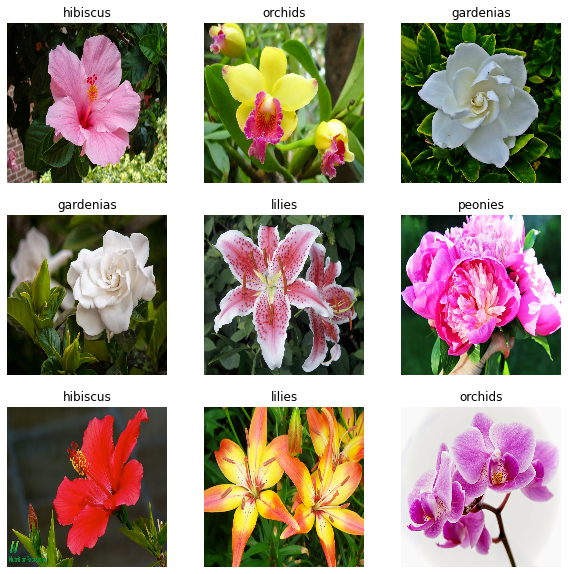

In [5]:
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [6]:
#Running an Optimizing Algorithm to find a good allocation of the CPU
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)

## 2.5 Data Augmentation<a id='2.5_data_augmentation'></a>

In [7]:
#Data Augmentation
def data_augmenter():
    '''
    Create a Sequential model composed of 3 layers
    Random Flip
    Random Rotate
    Random Zoom
    
    Returns:
        tf.keras.Sequential
    '''
    data_augmentation = tf.keras.Sequential()
    data_augmentation.add(RandomFlip('horizontal'))
    data_augmentation.add(RandomRotation(0.2))
    data_augmentation.add(RandomZoom(0.5, 0.2))
    
    return data_augmentation

In [8]:
#Initialize the augmenter
augmenter = data_augmenter()

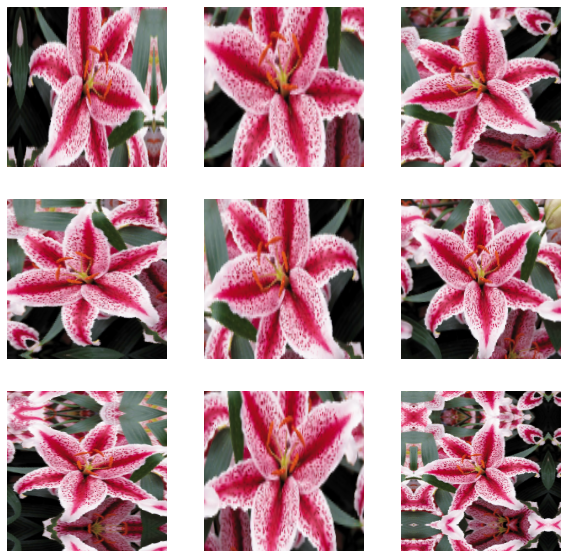

In [9]:
#Plot the augmented data
data_augmentation = data_augmenter()

for image, _ in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

## 2.6 Base Model<a id='2.6_base_model'></a>

In [10]:
def my_model(IMG_SIZE):
    """
    Implements the forward propagation for the binary classification model:
    ZEROPAD2D -> CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> FLATTEN -> DENSE
    
    Note that for simplicity and grading purposes, you'll hard-code all the values
    such as the stride and kernel (filter) sizes. 
    Normally, functions should take these values as function parameters.
    
    Arguments:
    None

    Returns:
    model -- TF Keras model (object containing the information for the entire training process) 
    """
    
    input_shape = IMG_SIZE + (3, )
    inputs = tf.keras.Input(shape=input_shape)
    x = data_augmentation(inputs)
    x = tf.keras.layers.Conv2D(filters = 64, kernel_size = (4, 4), strides = (1, 1), padding = 'same')(x)
    x = tf.keras.layers.BatchNormalization(axis = 3)(x)
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.MaxPool2D(pool_size = (8, 8), strides = (8, 8), padding = 'same')(x)
    x = tf.keras.layers.Conv2D(filters = 128, kernel_size = (2, 2), strides = (1, 1), padding = 'same')(x)
    x = tf.keras.layers.BatchNormalization(axis = 3)(x)
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.MaxPool2D(pool_size = (4, 4), strides = (4, 4), padding = 'same')(x)
    x = tf.keras.layers.Conv2D(filters = 256, kernel_size = (2, 2), strides = (1, 1), padding = 'same')(x)
    x = tf.keras.layers.BatchNormalization(axis = 3)(x)
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.MaxPool2D(pool_size = (2, 2), strides = (2, 2), padding = 'same')(x)
    x = tf.keras.layers.GlobalAveragePooling2D()(x) 
    #Added New to reduce Overfitting
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Flatten()(x) 

    outputs = tf.keras.layers.Dense(10, activation = 'softmax')(x)
    
    model = tf.keras.Model(inputs = inputs, outputs = outputs)
    
    return model

In [11]:
base_model = my_model(IMG_SIZE)

In [12]:
base_model.compile(optimizer=tf.keras.optimizers.Adam(lr = 0.0005),
               loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
               metrics=['accuracy'])

C:\Users\Neel Deorukhkar\Documents\Anaconda\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [13]:
base_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 160, 160, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 160, 160, 64)      3136      
                                                                 
 batch_normalization (BatchN  (None, 160, 160, 64)     256       
 ormalization)                                                   
                                                                 
 re_lu (ReLU)                (None, 160, 160, 64)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 20, 20, 64)       0         
 )                                                           

In [14]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=25)

In [15]:
history = base_model.fit(train_dataset, epochs=70, batch_size=32, validation_data=validation_dataset, callbacks=[es])

Epoch 1/70


C:\Users\Neel Deorukhkar\Documents\Anaconda\lib\site-packages\tensorflow\python\util\dispatch.py:1096: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


19/19 [==============================] - 12s 522ms/step - loss: 2.0740 - accuracy: 0.2879 - val_loss: 6.6814 - val_accuracy: 0.1575
Epoch 2/70
19/19 [==============================] - 11s 513ms/step - loss: 1.5596 - accuracy: 0.4753 - val_loss: 5.3313 - val_accuracy: 0.1507
Epoch 3/70
19/19 [==============================] - 11s 506ms/step - loss: 1.3572 - accuracy: 0.5673 - val_loss: 3.7652 - val_accuracy: 0.2260
Epoch 4/70
19/19 [==============================] - 11s 505ms/step - loss: 1.3020 - accuracy: 0.5622 - val_loss: 2.3872 - val_accuracy: 0.2740
Epoch 5/70
19/19 [==============================] - 11s 503ms/step - loss: 1.2320 - accuracy: 0.6065 - val_loss: 3.3176 - val_accuracy: 0.2055
Epoch 6/70
19/19 [==============================] - 11s 505ms/step - loss: 1.1575 - accuracy: 0.6014 - val_loss: 2.1250 - val_accuracy: 0.3425
Epoch 7/70
19/19 [==============================] - 11s 497ms/step - loss: 1.0977 - accuracy: 0.6405 - val_loss: 1.5151 - val_accuracy: 0.5068
Epoch 8/70

C:\Users\Neel Deorukhkar\Documents\Anaconda\lib\site-packages\pandas\core\frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


[Text(0, 0.5, 'Accuracy'), Text(0.5, 0, 'Epoch')]

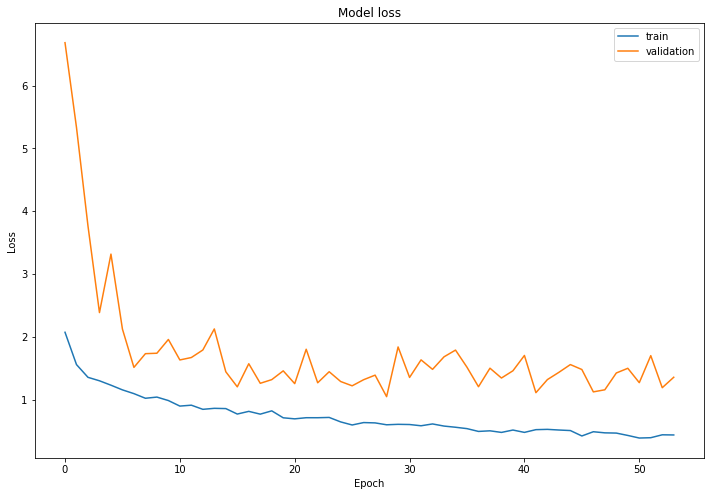

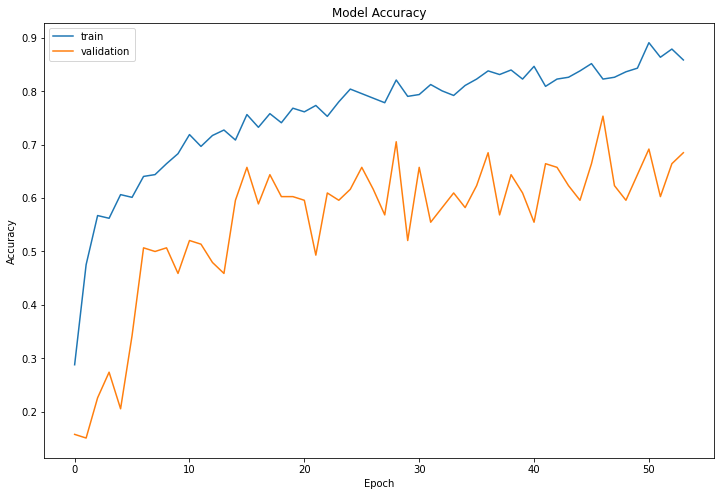

In [16]:
# The history.history["loss"] entry is a dictionary with as many values as epochs that the
# model was trained on. 
df_loss_acc = pd.DataFrame(history.history)
df_loss= df_loss_acc[['loss','val_loss']]
df_loss.rename(columns={'loss':'train','val_loss':'validation'},inplace=True)
df_acc= df_loss_acc[['accuracy','val_accuracy']]
df_acc.rename(columns={'accuracy':'train','val_accuracy':'validation'},inplace=True)
df_loss.plot(title='Model loss',figsize=(12,8)).set(xlabel='Epoch',ylabel='Loss')
df_acc.plot(title='Model Accuracy',figsize=(12,8)).set(xlabel='Epoch',ylabel='Accuracy')

In [17]:
base_model.evaluate(validation_dataset)

5/5 [==============================] - 1s 85ms/step - loss: 1.3583 - accuracy: 0.6849


[1.3583036661148071, 0.6849315166473389]

### Analyzing the base model output

As we can see above, the base model overfits the the training dataset. The training accuracy is around 98% whereas the validation accuracy is at 69%. 

Initially, I the validation accuracy was hovering around 40%. I used the following steps to improve the validation accuracy and improve validation loss:

1. Added Additional Convolutional layers --> CONV2D --> BATCHNORM --> RELU --> MAXPOOL2D   x 3
2. Increased the number of filters in each additional layer
3. Data Augmentation -- RandomFlip, RandomRotation and RandomZoom
4. To reduce Overfitting, I added a dropout of 0.2

So by adding new layers, increasing the number of filters, curating more data , we've been able to improve the model validation accuracy from 40% to almost 70%.

However, from a business perspective, 70% accuracy on the validation is not something the business owner is comfortable as that leads to a high misclassification rate.

**Based on the findings above, it's faster for us to use a pretrained model from Keras Applications and modify the pretrained model to reduce validation loss. We can do this by dropping the last softmax layer, and modifying the Dense layer to include only the number of classes**

## 2.7 Pretrained Flower Model<a id='2.6_flower_model'></a>

In [18]:
def flowers_model(image_shape=IMG_SIZE,
                  data_augmentation=data_augmenter(),
                  pretrained_model = tf.keras.applications.mobilenet_v2.MobileNetV2,
                  preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input,
                  num_classes = len(class_names)):
    ''' Define a tf.keras model for Multi classification out of the flowers model
    Arguments:
        image_shape -- Image width and height
        data_augmentation -- data augmentation function
        keras.applications -- Pretrainied Model
        keras.application.preprocess_input -- Preprocess the data
    Returns:
        tf.keras.model    '''    
    
    input_shape = image_shape + (3,)
        
    base_model = pretrained_model(input_shape=input_shape,
                                  include_top=False,
                                  weights='imagenet')
    
    # Freezing the Base model
    base_model.trainable = False 

    # Creating the Input layer as the same size as ImageNetV2
    inputs = tf.keras.Input(shape=input_shape) 
    
    # Data Augmemtation
    x = data_augmentation(inputs)
    
    # Preprocessing the data using the same weights as the pretrained model
    x = preprocess_input(x) 
    
    x = base_model(x, training=False)     
    x = tf.keras.layers.GlobalAveragePooling2D()(x) 
    x = tf.keras.layers.Dropout(0.2)(x)
     
    #Softmax for Multiclass    
    outputs = tf.keras.layers.Dense(num_classes, activation = 'softmax')(x)
    
    model = tf.keras.Model(inputs, outputs)
    
    return model

### 2.7.1 MobileNetV2<a id='2.6.1_MobileNetV2'></a>

In [19]:
model_mobileNetv2 = flowers_model(IMG_SIZE, data_augmentation)

In [20]:
model_mobileNetv2.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 160, 160, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 160, 160, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                           

In [21]:
model_mobileNetv2.compile(optimizer=tf.keras.optimizers.Adam(lr = 0.001),
               loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
               metrics=['accuracy'])

C:\Users\Neel Deorukhkar\Documents\Anaconda\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [22]:
initial_epochs = 70
history = model_mobileNetv2.fit(train_dataset, validation_data=validation_dataset, epochs=initial_epochs, callbacks= [es])

Epoch 1/70


C:\Users\Neel Deorukhkar\Documents\Anaconda\lib\site-packages\tensorflow\python\util\dispatch.py:1096: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


19/19 [==============================] - 9s 324ms/step - loss: 2.1239 - accuracy: 0.2743 - val_loss: 1.4201 - val_accuracy: 0.5685
Epoch 2/70
19/19 [==============================] - 7s 294ms/step - loss: 1.0869 - accuracy: 0.6610 - val_loss: 0.9200 - val_accuracy: 0.7603
Epoch 3/70
19/19 [==============================] - 7s 297ms/step - loss: 0.7579 - accuracy: 0.7836 - val_loss: 0.7411 - val_accuracy: 0.8082
Epoch 4/70
19/19 [==============================] - 7s 297ms/step - loss: 0.6128 - accuracy: 0.8143 - val_loss: 0.6365 - val_accuracy: 0.8356
Epoch 5/70
19/19 [==============================] - 7s 297ms/step - loss: 0.5000 - accuracy: 0.8603 - val_loss: 0.5750 - val_accuracy: 0.8288
Epoch 6/70
19/19 [==============================] - 7s 295ms/step - loss: 0.4670 - accuracy: 0.8450 - val_loss: 0.5572 - val_accuracy: 0.8425
Epoch 7/70
19/19 [==============================] - 7s 293ms/step - loss: 0.4027 - accuracy: 0.8705 - val_loss: 0.5372 - val_accuracy: 0.8356
Epoch 8/70
19/19 

19/19 [==============================] - 7s 299ms/step - loss: 0.0753 - accuracy: 0.9813 - val_loss: 0.3768 - val_accuracy: 0.8836
Epoch 59/70
19/19 [==============================] - 7s 295ms/step - loss: 0.0727 - accuracy: 0.9796 - val_loss: 0.3469 - val_accuracy: 0.8904
Epoch 60/70
19/19 [==============================] - 7s 300ms/step - loss: 0.0833 - accuracy: 0.9796 - val_loss: 0.3547 - val_accuracy: 0.8904
Epoch 61/70
19/19 [==============================] - 7s 299ms/step - loss: 0.0741 - accuracy: 0.9864 - val_loss: 0.3618 - val_accuracy: 0.8904
Epoch 62/70
19/19 [==============================] - 7s 297ms/step - loss: 0.0696 - accuracy: 0.9813 - val_loss: 0.3718 - val_accuracy: 0.8973
Epoch 63/70
19/19 [==============================] - 7s 295ms/step - loss: 0.0601 - accuracy: 0.9881 - val_loss: 0.4034 - val_accuracy: 0.8767
Epoch 64/70
19/19 [==============================] - 7s 300ms/step - loss: 0.0636 - accuracy: 0.9881 - val_loss: 0.3544 - val_accuracy: 0.8767
Epoch 65/70

In [23]:
model_mobileNetv2.evaluate(validation_dataset)

5/5 [==============================] - 1s 144ms/step - loss: 0.3612 - accuracy: 0.8904


[0.36123138666152954, 0.8904109597206116]

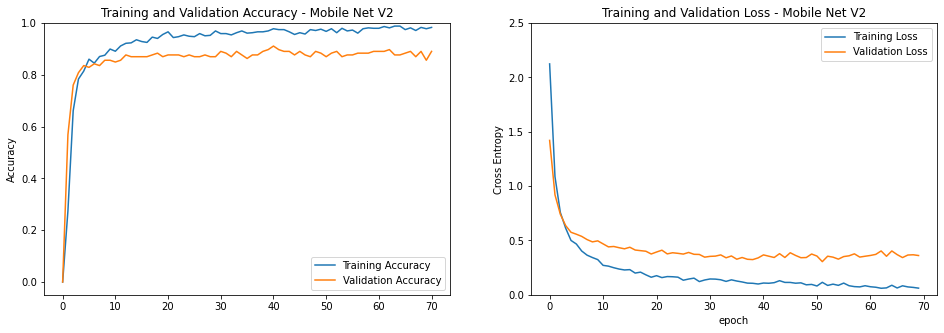

In [24]:
acc = [0.] + history.history['accuracy']
val_acc = [0.] + history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(16, 5))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy - Mobile Net V2')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,2.5])
plt.title('Training and Validation Loss - Mobile Net V2')
plt.xlabel('epoch')
plt.show()

### Analyzing the MobileNetv2 model output

Clearly, using a pretrained model has saved time and increased the validation accuracy to 90%. The business owner is much satisfied with the results, and accepts an accuracy of 90%.

The time per epoch is 300 ms which is pretty fast.

We could try different pretrained models to see whether the accuracy improves

## 2.7.2 VGG16 <a id='2.6.2_VGG16'></a>

In [25]:
model_vgg16 = flowers_model(IMG_SIZE, data_augmentation,
                           pretrained_model = tf.keras.applications.vgg16.VGG16,
                           preprocess_input = tf.keras.applications.vgg16.preprocess_input)
model_vgg16.compile(optimizer=tf.keras.optimizers.Adam(lr = 0.001),
               loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
               metrics=['accuracy'])
initial_epochs = 70
history_vgg16 = model_vgg16.fit(train_dataset, validation_data=validation_dataset, epochs=initial_epochs)

Epoch 1/70
19/19 [==============================] - 33s 2s/step - loss: 8.6504 - accuracy: 0.1533 - val_loss: 6.1530 - val_accuracy: 0.3082
Epoch 2/70
19/19 [==============================] - 32s 2s/step - loss: 5.8592 - accuracy: 0.2283 - val_loss: 4.0532 - val_accuracy: 0.3973
Epoch 3/70
19/19 [==============================] - 32s 2s/step - loss: 4.6434 - accuracy: 0.2998 - val_loss: 3.2858 - val_accuracy: 0.4863
Epoch 4/70
19/19 [==============================] - 32s 2s/step - loss: 3.2518 - accuracy: 0.4276 - val_loss: 2.5345 - val_accuracy: 0.5753
Epoch 5/70
19/19 [==============================] - 32s 2s/step - loss: 2.6077 - accuracy: 0.4991 - val_loss: 2.1989 - val_accuracy: 0.5685
Epoch 6/70
19/19 [==============================] - 33s 2s/step - loss: 2.2334 - accuracy: 0.5315 - val_loss: 1.9057 - val_accuracy: 0.6027
Epoch 7/70
19/19 [==============================] - 33s 2s/step - loss: 2.0768 - accuracy: 0.5520 - val_loss: 1.6874 - val_accuracy: 0.6233
Epoch 8/70
19/19 [==

19/19 [==============================] - 33s 2s/step - loss: 0.3492 - accuracy: 0.8807 - val_loss: 0.4507 - val_accuracy: 0.8699
Epoch 60/70
19/19 [==============================] - 33s 2s/step - loss: 0.3171 - accuracy: 0.9114 - val_loss: 0.5166 - val_accuracy: 0.8630
Epoch 61/70
19/19 [==============================] - 33s 2s/step - loss: 0.2845 - accuracy: 0.9080 - val_loss: 0.4751 - val_accuracy: 0.8630
Epoch 62/70
19/19 [==============================] - 33s 2s/step - loss: 0.2737 - accuracy: 0.9029 - val_loss: 0.5204 - val_accuracy: 0.8630
Epoch 63/70
19/19 [==============================] - 33s 2s/step - loss: 0.3950 - accuracy: 0.8739 - val_loss: 0.5693 - val_accuracy: 0.8493
Epoch 64/70
19/19 [==============================] - 33s 2s/step - loss: 0.2912 - accuracy: 0.9029 - val_loss: 0.5348 - val_accuracy: 0.8425
Epoch 65/70
19/19 [==============================] - 33s 2s/step - loss: 0.3153 - accuracy: 0.9097 - val_loss: 0.4563 - val_accuracy: 0.8493
Epoch 66/70
19/19 [======

In [26]:
model_vgg16.evaluate(validation_dataset)

5/5 [==============================] - 7s 1s/step - loss: 0.5020 - accuracy: 0.8493


[0.501993715763092, 0.8493150472640991]

#### Ploting Accuracy and Validation Loss

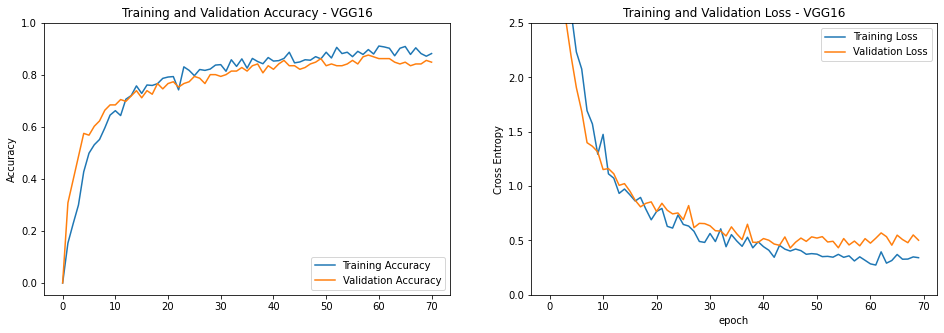

In [27]:
acc = [0.] + history_vgg16.history['accuracy']
val_acc = [0.] + history_vgg16.history['val_accuracy']

loss = history_vgg16.history['loss']
val_loss = history_vgg16.history['val_loss']

plt.figure(figsize=(16, 5))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy - VGG16')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0, 2.5])
plt.title('Training and Validation Loss - VGG16')
plt.xlabel('epoch')
plt.show()

### Analyzing the VGG16 model output

The VGG16 model is much slower than the MobileNetV2 model because of the size of the network and number of parameters. Secondly, the model predicts better than the base model but much more poorly than the MobileNetV2 model.

This gives a sense that not all pretrained models work in the similar way. We can try out the ResNet50 model next to see the performance

## 2.7.3 ResNet50 <a id='2.6.3_resnet50'></a>

In [28]:
model_resnet50 = flowers_model(IMG_SIZE, data_augmentation,
                           pretrained_model = tf.keras.applications.resnet50.ResNet50,
                           preprocess_input = tf.keras.applications.resnet50.preprocess_input)
model_resnet50.compile(optimizer=tf.keras.optimizers.Adam(lr = 0.001),
               loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
               metrics=['accuracy'])
initial_epochs = 70
history_resnet50 = model_resnet50.fit(train_dataset, validation_data=validation_dataset, epochs=initial_epochs)

Epoch 1/70
19/19 [==============================] - 19s 843ms/step - loss: 2.1318 - accuracy: 0.3083 - val_loss: 0.9794 - val_accuracy: 0.6712
Epoch 2/70
19/19 [==============================] - 16s 807ms/step - loss: 0.9404 - accuracy: 0.7019 - val_loss: 0.6176 - val_accuracy: 0.7534
Epoch 3/70
19/19 [==============================] - 16s 817ms/step - loss: 0.6572 - accuracy: 0.7819 - val_loss: 0.5247 - val_accuracy: 0.7945
Epoch 4/70
19/19 [==============================] - 17s 822ms/step - loss: 0.5406 - accuracy: 0.8348 - val_loss: 0.4586 - val_accuracy: 0.8151
Epoch 5/70
19/19 [==============================] - 17s 817ms/step - loss: 0.4455 - accuracy: 0.8637 - val_loss: 0.4218 - val_accuracy: 0.8493
Epoch 6/70
19/19 [==============================] - 16s 815ms/step - loss: 0.3861 - accuracy: 0.8739 - val_loss: 0.3998 - val_accuracy: 0.8288
Epoch 7/70
19/19 [==============================] - 17s 829ms/step - loss: 0.3723 - accuracy: 0.8756 - val_loss: 0.3770 - val_accuracy: 0.8493

Epoch 58/70
19/19 [==============================] - 17s 817ms/step - loss: 0.0766 - accuracy: 0.9779 - val_loss: 0.4033 - val_accuracy: 0.8767
Epoch 59/70
19/19 [==============================] - 16s 813ms/step - loss: 0.0769 - accuracy: 0.9744 - val_loss: 0.3664 - val_accuracy: 0.8904
Epoch 60/70
19/19 [==============================] - 17s 818ms/step - loss: 0.0651 - accuracy: 0.9898 - val_loss: 0.3312 - val_accuracy: 0.8836
Epoch 61/70
19/19 [==============================] - 17s 829ms/step - loss: 0.0537 - accuracy: 0.9898 - val_loss: 0.3307 - val_accuracy: 0.8904
Epoch 62/70
19/19 [==============================] - 17s 831ms/step - loss: 0.0755 - accuracy: 0.9796 - val_loss: 0.3501 - val_accuracy: 0.8904
Epoch 63/70
19/19 [==============================] - 17s 824ms/step - loss: 0.0619 - accuracy: 0.9864 - val_loss: 0.3751 - val_accuracy: 0.8767
Epoch 64/70
19/19 [==============================] - 17s 818ms/step - loss: 0.0675 - accuracy: 0.9796 - val_loss: 0.3714 - val_accuracy:

#### Ploting Accuracy and Validation Loss

In [29]:
model_resnet50.evaluate(validation_dataset)

5/5 [==============================] - 3s 537ms/step - loss: 0.3821 - accuracy: 0.8836


[0.3821439743041992, 0.8835616707801819]

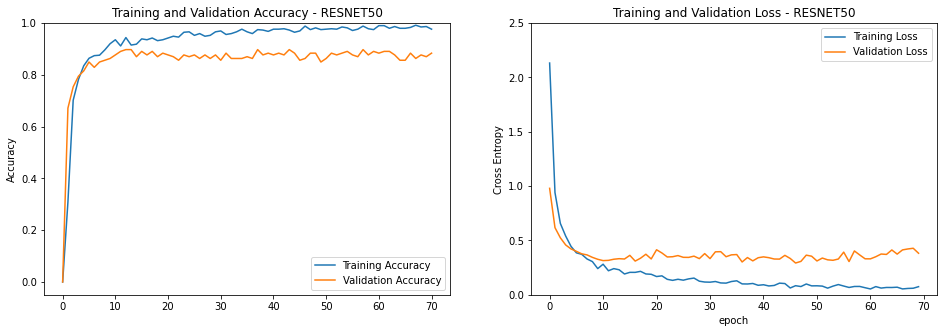

In [30]:
acc = [0.] + history_resnet50.history['accuracy']
val_acc = [0.] + history_resnet50.history['val_accuracy']

loss = history_resnet50.history['loss']
val_loss = history_resnet50.history['val_loss']

plt.figure(figsize=(16, 5))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy - RESNET50')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,2.5])
plt.title('Training and Validation Loss - RESNET50')
plt.xlabel('epoch')
plt.show()

### Analyzing the ResNet50 model output

The Resnet50 model does better than the base model and VGG16 model and has an overall validation accuracy of 84%. This is pretty good, but the Mobile V2 Model is the best in terms of accuracy and lowest validation loss.

## 2.8 Model Comparison<a id='2.8_model_comparison'></a>

|Model||Validation_Accuracy||Validation_loss||Time per Epoch|
|-----||-------------------||---------------||--------------|
|base_model||70%           ||1.32           || 500ms        |
|**MobileNetV2**||**89%**          ||**0.35**           || **350ms**        |
|VGG16||85%||0.50||34s|
|ResNet50||88%||0.38||786ms|

From the 3 models run above, it is evident that MobileNet v2 and ResNet50 work the best. VGG16 shows the worst performance out of all the three models and takes almost 34 secs per epoch.

Based on the performance, MobileNetV2 has the fastest training time and lowest validation loss. We can use the MobileNetV2 to predict image labels.

## 2.9 Model Prediction<a id='2.9_model_prediction'></a>

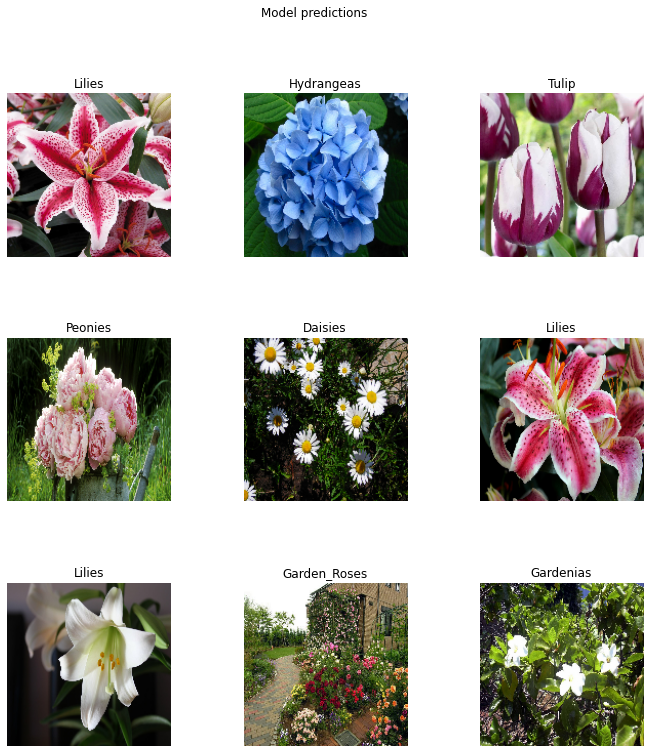

In [31]:
# get and decode the predictions
predicted_batch = model_mobileNetv2.predict(image)
predicted_id = tf.math.argmax(predicted_batch, axis=-1)
predicted_label = class_names[predicted_id]
plt.figure(figsize=(12,12))
plt.subplots_adjust(hspace=0.5)
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(image[i] / 255.0)
    plt.title(predicted_label[i].title())
    plt.axis('off')
    plt.tight_layout
    plt.suptitle('Model predictions')

## 2.10 Summary<a id='2.10_model_summary'></a>

As you can see above, the image classifier correctly classified the images above. The overall validation accuracy hovers around 85%, and the business owner of the flower shop is statisfied with this level of accuracy. 